<a href="https://colab.research.google.com/github/mayanksreal/marks-evaluation/blob/main/notebook_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Number Recognition Model (CNN)

## Importing Libraries

In [175]:
!pip install easyocr
!pip install pymupdf
import io
import PIL
import numpy as np
import os
import cv2
import csv

from tensorflow.keras.preprocessing import image #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.datasets import mnist #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input #type:ignore
from tensorflow.keras.callbacks import EarlyStopping #type:ignore

import easyocr
reader = easyocr.Reader(['en'])
import pymupdf

## Importing Dataset

In [145]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()

In [146]:
print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


60000 samples of 28x28 px in train \
10000 samples of 28x28 px in test

## Reshaping

We reshape it to 28,28,1 because Conv2D expects color value

In [147]:
x_train, y_train = x_train.reshape(60000, 28,28,1) , y_train.reshape(60000, 1)
x_test, y_test = x_test.reshape(10000, 28,28,1) , y_test.reshape(10000, 1)

In [148]:
print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))

(60000, 28, 28, 1) (60000, 1)
(10000, 28, 28, 1) (10000, 1)


## Normalization

In [149]:
x_train, x_test = x_train/255.0 , x_test/255.0

## Building Model

In [150]:
model = Sequential()

In [151]:
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [183]:
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

## Training

In [184]:
model.fit(x = x_train , y = y_train, validation_split = 0.2, epochs = 15, batch_size = 1000, callbacks = [early])

Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9966 - loss: 0.0095 - val_accuracy: 0.9874 - val_loss: 0.0521
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9982 - loss: 0.0051 - val_accuracy: 0.9879 - val_loss: 0.0485
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9881 - val_loss: 0.0532
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9873 - val_loss: 0.0574
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9874 - val_loss: 0.0511
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9866 - val_loss: 0.0582


In [185]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - loss: 0.0490


[0.039113838225603104, 0.989799976348877]

# OCR/ CNN function

## CNN

In [155]:
def hand_prediction(img_obj):
    image = img_obj
    def remove_borders(image, border_size=5):
        # Crop out the borders by a fixed size
        return image[border_size:-border_size, border_size:-border_size]
    # Remove borders from the entire image
    image = remove_borders(image, border_size=5)

    image = cv2. cvtColor(image, cv2. COLOR_BGR2GRAY)

    # Apply binary thresholding to the image
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by their x position
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    digits = []

    global num
    num = 0

    for ctr in contours:
        num = num*10
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(ctr)

        # Add padding to the bounding box
        padding = 5  # Adjust padding as needed
        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, image.shape[1] - x)
        h = min(h + 2 * padding, image.shape[0] - y)

        # Extract the digit using the bounding box
        digit = thresh[y:y+h, x:x+w]
        # Resizing to fit model input
        resized_digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
        # Normalization
        digit = resized_digit / 255.0

        num = num + np.argmax(model.predict(digit.reshape(1,28,28,1)))
    return num

In [156]:
from google.colab.patches import cv2_imshow

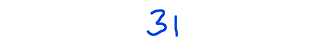

In [157]:
image = cv2.imread("data/cell.png")
cv2_imshow(image)

In [158]:
print(hand_prediction(image))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
31


## OCR

In [159]:
def ocr_prediction(img_obj):
    try:
        results = reader.readtext(img_obj)
        result_set = set()
        if len(results) > 1:
            for x in results[0][1]:
                result_set.add(x)
            for x in results[1][1]:
                result_set.add(x)
            attention = False
            if  len( (results[0][1])+(results[1][1]) ) - len(result_set) > 5:
                attention = True
        if results:
            return results
        else:
            return 'ERR'
    except Exception as e:
        return 'ERR'

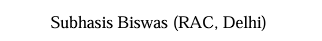

In [160]:
image = cv2.imread("data/cell.png")
cv2_imshow(image)

In [161]:
print(ocr_prediction(image))

[([[49, 13], [269, 13], [269, 33], [49, 33]], 'Subhasis Biswas (RAC, Delhi)', 0.9989174798683293)]


In [162]:
print(f"{ocr_prediction(image)[0][1]}  ({round(ocr_prediction(image)[0][2]*100,2)}%)")

Subhasis Biswas (RAC, Delhi)  (99.89%)


# Extracting Data

In [163]:
def read_pdf(pdf_path):
    pdf_document = pymupdf.open(pdf_path)
    global rows_written
    rows_written = 0

    if not os.path.exists('outputs'):
        os.makedirs('outputs')


    #Clearing any past file
    with open('outputs/output.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file)

    with open('outputs/attention.txt', mode='w') as txt_file:
        txt_write = txt_file.write('')

    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        # To image (using matrix transformation)
        zoom = 2  # Adjust zoom level as needed
        mat = pymupdf.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)

        # pixmap to PIL Image
        img_bytes = pix.tobytes("ppm")
        image = PIL.Image.open(io.BytesIO(img_bytes))

        image = np.array(image)
        return image

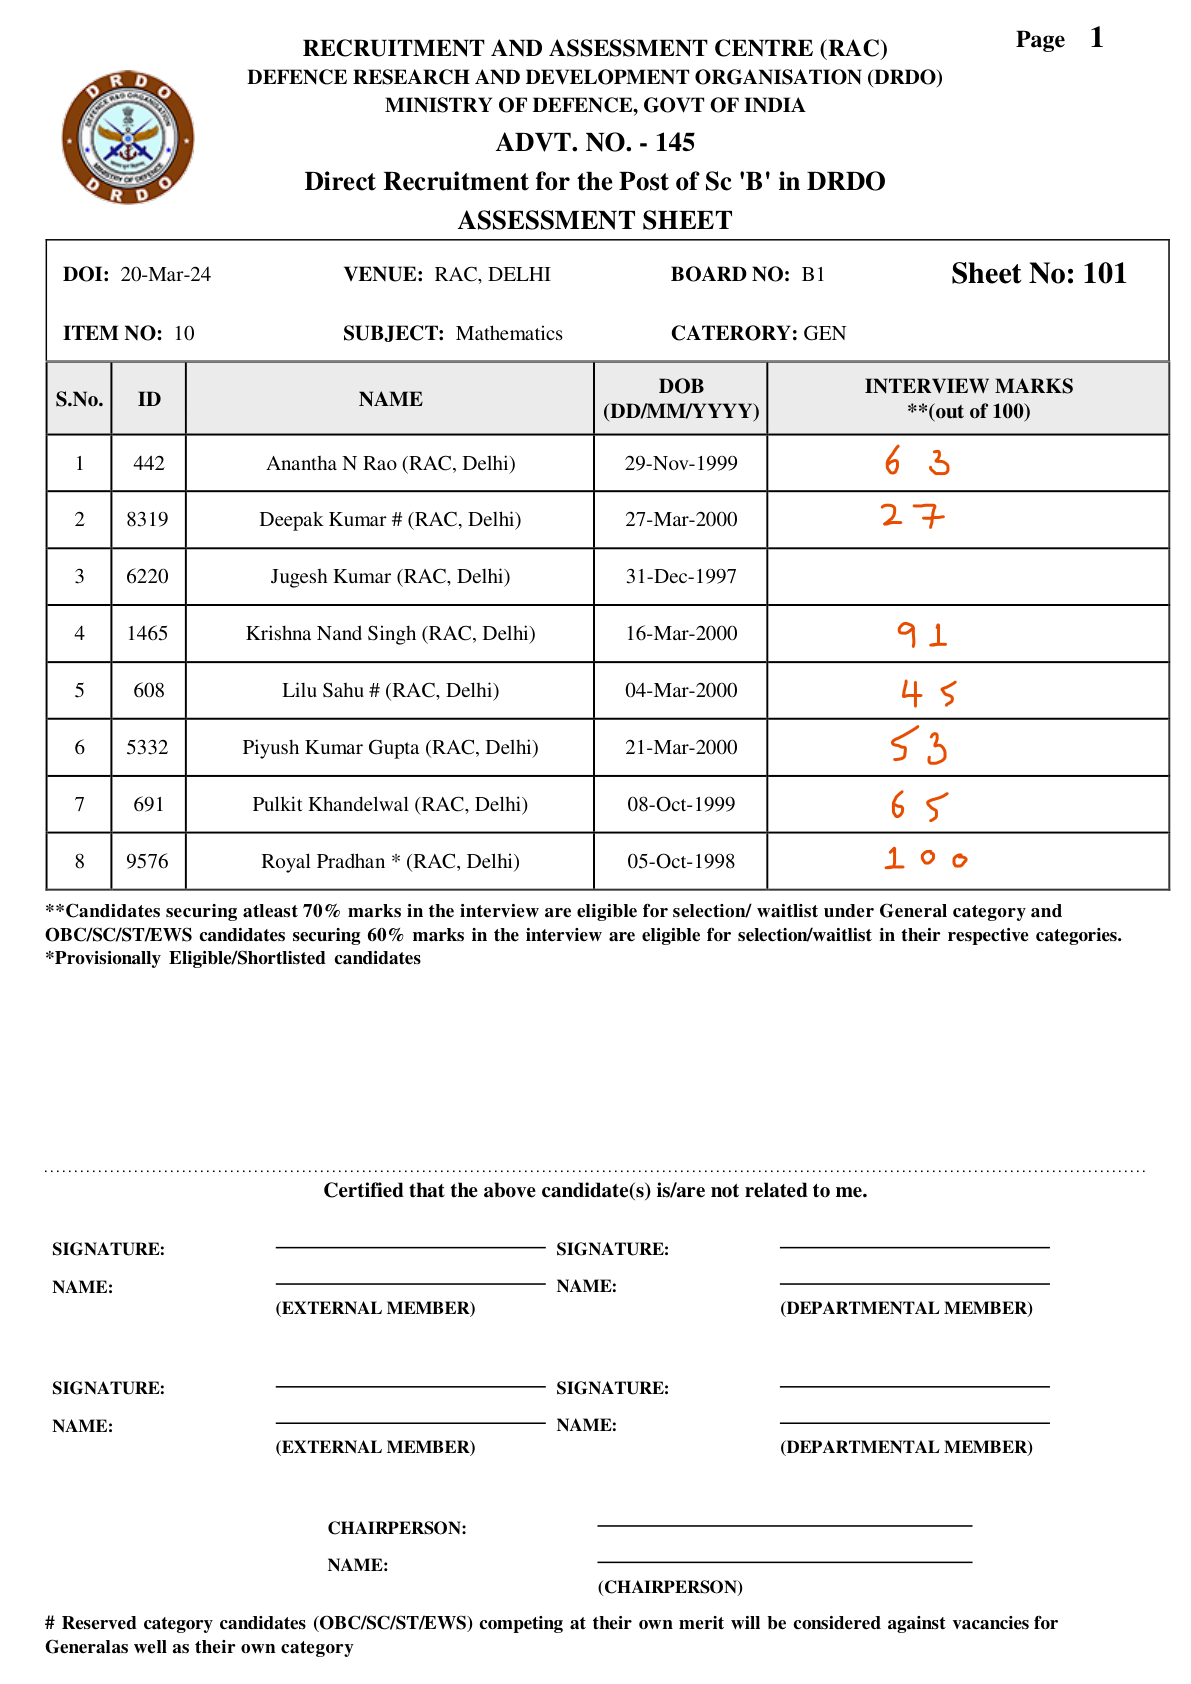

In [164]:
img = read_pdf("data/pdf-marked-demo.pdf")
cv2_imshow(img)

In [165]:
from matplotlib import pyplot as plt

In [166]:
def get_table(image):
    ## Filters
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)


    ## Contour detection
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
    table_contour = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            table_contour = approx
            break

    if table_contour is not None:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(table_contour)

        # Crop the table region from the original image
        table_image = image[y:y+h, x:x+w]
        num_rows = 0
        return table_image
    else:
        print("error")


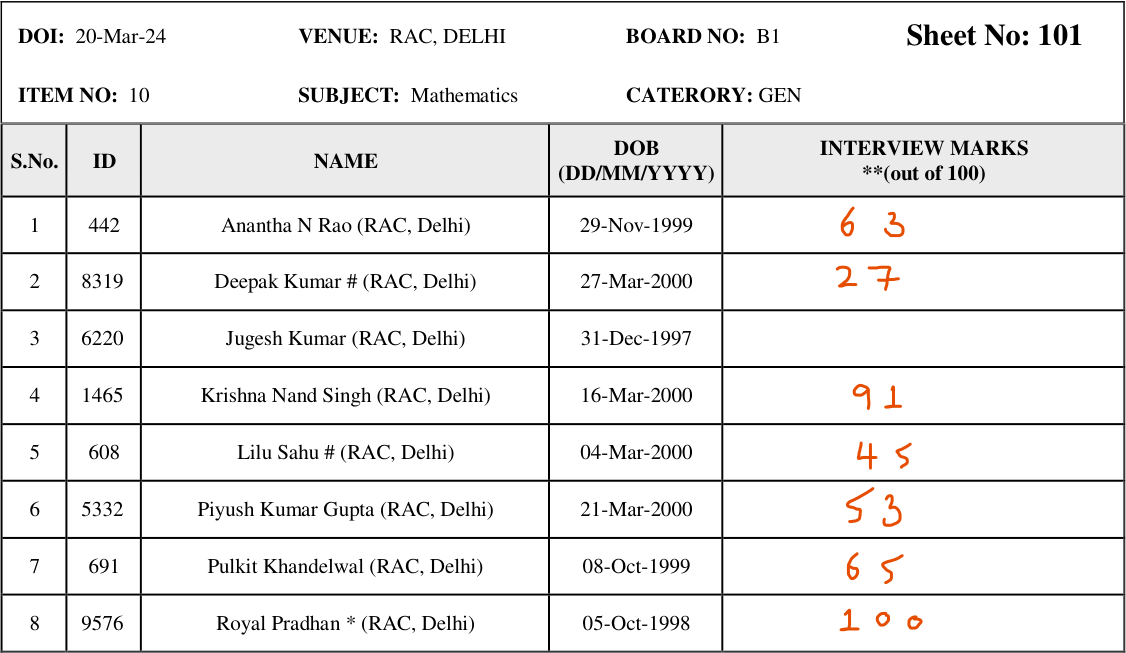

In [167]:
image = get_table(img)
cv2_imshow(image)

In [168]:
def extract_cells_to_csv(image, csv_filename='outputs/output.csv'):

    # Determine number of rows using page height
    # height = 181 + 59*rows
    height = len(image)
    num_rows = round((height - 181) / 59)
    global rows_written

    # Parameters (adjust these values as needed)
    title_offset = 106 + (num_rows * 2)  # Offset to skip the title
    header_row_height = 75  # Height of the header row
    row_height = 57  # Height of each subsequent row

    # Column widths (adjust these values according to your table)
    col_names = ["SNo.","ID","NAME","DOB","INTERVIEW MARKS"]
    column_widths = [67, 73, 392 + (num_rows * 2), 175, 380]

    # Function to get the column boundaries
    def get_column_boundaries(column_widths):
        boundaries = [0]
        for width in column_widths:
            boundaries.append(boundaries[-1] + width)
        return boundaries

    column_boundaries = get_column_boundaries(column_widths)

    # Open a CSV file to write the results
    with open(csv_filename, mode='a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Extract header row
        header_row = image[title_offset:title_offset + header_row_height, :]
        header_cells = []

        # Process each cell of the header row
        for col in range(0,5):
            cell = header_row[:, column_boundaries[col]:column_boundaries[col + 1]]
            cell_image = np.array(cell)
            header_cells.append(ocr_prediction(cell_image)[0][1])

        # Write the header row to the CSV
        csv_writer.writerow(header_cells)

        # Extract subsequent rows
        for row in range(1, num_rows + 1):
            row_start = title_offset + header_row_height + (row - 1) * row_height
            row_end = row_start + row_height
            table_row = image[row_start:row_end, :]
            row_cells = []

            # Process each cell of the row
            row_cells.append(f'{row + rows_written}')
            for col in range(1,5):
                cell = table_row[:, column_boundaries[col]:column_boundaries[col + 1]]
                cell_image = np.array(cell)
                if col < 4:
                   row_cells.append(ocr_prediction(cell_image)[0][1])
                   if len(ocr_prediction(cell_image)) > 1:
                       txt_file = open("outputs/attention.txt", "a", newline="\n")
                       txt_file.write(f"Attention needed at: SNo. {rows_written + row} , {col_names[col]} \n")
                if col == 4:
                    r = hand_prediction(cell_image)
                    row_cells.append(r)
                    cv2_imshow(cell_image)
                    print(r)

            # Write the row to the CSV
            csv_writer.writerow(row_cells)

    print(f"Written {num_rows} row(s) to '{csv_filename}'.")
    rows_written += num_rows

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


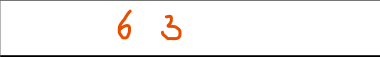

63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


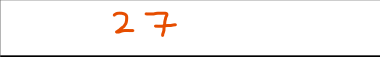

23


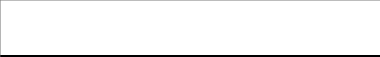

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


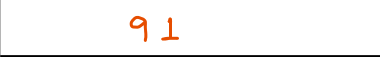

91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


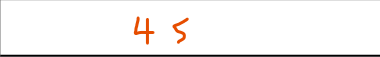

45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


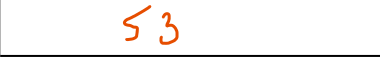

53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


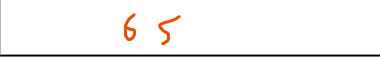

65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


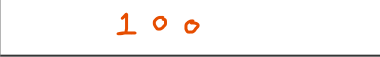

109
Written 8 row(s) to 'outputs/output.csv'.


In [169]:
page = read_pdf("data/pdf-marked-demo.pdf")
table = get_table(page)
extract_cells_to_csv(table)

### ALL PAGES
Now for all pages, we cascadingly call all functions, in a for loop


In [170]:
def read_pdf(pdf_path):
    pdf_document = pymupdf.open(pdf_path)
    global rows_written
    rows_written = 0

    if not os.path.exists('outputs'):
        os.makedirs('outputs')


    #Clearing any past file
    with open('outputs/output.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file)

    with open('outputs/attention.txt', mode='w') as txt_file:
        txt_write = txt_file.write('')

    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)
        # To image (using matrix transformation)
        zoom = 2  # Adjust zoom level as needed
        mat = pymupdf.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)

        # pixmap to PIL Image
        img_bytes = pix.tobytes("ppm")
        image = PIL.Image.open(io.BytesIO(img_bytes))

        image = np.array(image)

        #return image

        #instead lets read all pages

        table = get_table(image, page_number)

In [171]:
def get_table(image, page_number):
    ## Filters
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)


    ## Contour detection
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
    table_contour = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        if len(approx) == 4:
            table_contour = approx
            break

    if table_contour is not None:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(table_contour)

        # Crop the table region from the original image
        table_image = image[y:y+h, x:x+w]
        num_rows = 0

        #return table_image

        extract_cells_to_csv(table_image, page_number)

    else:
        print("error")

In [172]:
def extract_cells_to_csv(image, page_number, csv_filename='outputs/output.csv'):

    # Determine number of rows using page height
    # height = 181 + 59*rows
    height = len(image)
    num_rows = round((height - 181) / 59)
    global rows_written

    # Parameters (adjust these values as needed)
    title_offset = 106 + (num_rows * 2)  # Offset to skip the title
    header_row_height = 75  # Height of the header row
    row_height = 57  # Height of each subsequent row

    # Column widths (adjust these values according to your table)
    col_names = ["SNo.","ID","NAME","DOB","INTERVIEW MARKS"]
    column_widths = [67, 73, 392 + (num_rows * 2), 175, 380]

    # Function to get the column boundaries
    def get_column_boundaries(column_widths):
        boundaries = [0]
        for width in column_widths:
            boundaries.append(boundaries[-1] + width)
        return boundaries

    column_boundaries = get_column_boundaries(column_widths)

    # Open a CSV file to write the results
    with open(csv_filename, mode='a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        if page_number == 0:
          # Extract header row
          header_row = image[title_offset:title_offset + header_row_height, :]
          header_cells = []

          # Process each cell of the header row
          for col in range(0,5):
              cell = header_row[:, column_boundaries[col]:column_boundaries[col + 1]]
              cell_image = np.array(cell)
              header_cells.append(ocr_prediction(cell_image)[0][1])

          # Write the header row to the CSV
          csv_writer.writerow(header_cells)

        # Extract subsequent rows
        for row in range(1, num_rows + 1):
            row_start = title_offset + header_row_height + (row - 1) * row_height
            row_end = row_start + row_height
            table_row = image[row_start:row_end, :]
            row_cells = []

            # Process each cell of the row
            row_cells.append(f'{row + rows_written}')
            for col in range(1,5):
                cell = table_row[:, column_boundaries[col]:column_boundaries[col + 1]]
                cell_image = np.array(cell)
                if col < 4:
                   row_cells.append(ocr_prediction(cell_image)[0][1])
                   if len(ocr_prediction(cell_image)) > 1:
                       txt_file = open("outputs/attention.txt", "a", newline="\n")
                       txt_file.write(f"Attention needed at: SNo. {rows_written + row} , {col_names[col]} \n")
                if col == 4:
                    r = hand_prediction(cell_image)
                    row_cells.append(r[0])
                    if r[1] > 0.95:
                      txt_file = open("outputs/attention.txt", "a", newline="\n")
                      txt_file.write(f"Attention needed at: SNo. {rows_written + row} , {col_names[col]} \n")

            # Write the row to the CSV
            csv_writer.writerow(row_cells)

    print(f"Written {num_rows} row(s) to '{csv_filename}'.")
    rows_written += num_rows

ADDING PROBABILITY BASED WARNING FOR CNN

In [173]:
def hand_prediction(img_obj):
    image = img_obj
    def remove_borders(image, border_size=5):
        # Crop out the borders by a fixed size
        return image[border_size:-border_size, border_size:-border_size]
    # Remove borders from the entire image
    image = remove_borders(image, border_size=5)

    image = cv2. cvtColor(image, cv2. COLOR_BGR2GRAY)

    # Apply binary thresholding to the image
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by their x position
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    digits = []

    global num
    global probability
    global n
    num = 0
    probability = 0
    n = 1

    for ctr in contours:
        num = num*10
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(ctr)

        # Add padding to the bounding box
        padding = 5  # Adjust padding as needed
        x = max(x - padding, 0)
        y = max(y - padding, 0)
        w = min(w + 2 * padding, image.shape[1] - x)
        h = min(h + 2 * padding, image.shape[0] - y)

        # Extract the digit using the bounding box
        digit = thresh[y:y+h, x:x+w]
        # Resizing to fit model input
        resized_digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
        # Normalization
        digit = resized_digit / 255.0
        r = model.predict(digit.reshape(1,28,28,1))
        num = num + np.argmax(r)
        probability = probability + np.max(r)
        n = n+1

    return [num, probability/n]

In [174]:
read_pdf("data/pdf-marked-demo.pdf")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Written 8 row(s) to 'outputs/output.csv'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Written 3 row(s) to 'outputs/output.csv'.
